
# Generate a QA Evaluation Dataset from ChromaDB (10% sample) for RAG Testing
<img src="https://raw.githubusercontent.com/CNUClasses/CPSC471/master/content/lectures/week13/generate_synthetic_dataset_no_heading.png" alt="standard" style="max-height:300px;  margin:10px 0; vertical-align:middle;">

**Goal:** Build an **evaluation dataset** for RAG by sampling **10%** of a **pre‑chunked ChromaDB** collection and generating up to **5 question–answer pairs per chunk** using **OpenAI** *or* a **Hugging Face** model. Save the result to **CSV**.

### Why a relatively powerful LLM for question generation?
- **Answerability & grounding:** It must read a chunk and ask **non‑trivial but answerable** questions grounded **only** in that chunk (no outside knowledge).  
- **Paraphrase variety:** Better models generate diverse phrasings.  
- **Domain nuance:** Strong models handle **technical jargon** and produce **faithful** answers rather than hallucinations.  But this may break down in specialized fields with unique vocabulary/phrasing such as law or medical.
- **Format adherence:** Higher‑end models more reliably output **valid JSON** you can parse automatically.

> This notebook keeps costs in check by sampling **10%** of chunks and capping to **≤5 Q/A per chunk**.  



## 0) Setup & Installation

Uncomment the cell below if you need to install dependencies.  
We support **either** OpenAI **or** Hugging Face for question generation.


In [2]:

# !pip install -U chromadb openai transformers accelerate torch pandas numpy tqdm python-dotenv
# If you're on Apple Silicon:
# !pip install 'torch>=2.2.0' --index-url https://download.pytorch.org/whl/cpu



### Configuration
- **ChromaDB:** point to your persisted DB folder and collection name.  
- **Sampling:** set `SAMPLE_FRACTION=0.10` (10%).  
- **Generation choice:** set `USE_OPENAI=True` (needs `OPENAI_API_KEY`) or `USE_HF=True` (downloads HF model).  
- **Safety knobs:** `MAX_Q_PER_CHUNK` (≤5), `MAX_CHARS_PER_CHUNK` to truncate very long chunks.

> If both `USE_OPENAI` and `USE_HF` are True, OpenAI is used by default.


In [ ]:

import os
import json
import random
from typing import List, Dict, Any
from dataclasses import dataclass

import torch

torch.set_default_device('cuda:1')

# ---- User-editable parameters ----
PERSIST_DIR = "../week12/rag_chroma"        # ChromaDB persistence path (folder will be created)
# PERSIST_DIR = os.getenv("../week12", "./rag_chroma")
COLLECTION_NAME= "cnu_rag_lab"                       # collection name used previously
# COLLECTION_NAME   = os.getenv("cnu_rag_lab", "my_chunks")

SAMPLE_FRACTION   = float(os.getenv("SAMPLE_FRACTION", "0.2"))  # 20% of total chunks for train/valid/test
VALID_FRACTION  = float(os.getenv("VALID_FRACTION", "0.5"))   # 50% of SAMPLED chunks for validation
# TEST_FRACTION   = float(os.getenv("TEST_FRACTION", "0.25"))    # 25% of SAMPLED chunks for testing

MAX_Q_PER_CHUNK   = int(os.getenv("MAX_Q_PER_CHUNK", "5"))       # cap at 5
MAX_CHARS_PER_CHUNK = int(os.getenv("MAX_CHARS_PER_CHUNK", "3000")) #we cap out at 1532 I think so the chunk preview should be the entire chunk
RANDOM_SEED       = int(os.getenv("RANDOM_SEED", "471"))

# Generation backends
USE_OPENAI = os.getenv("USE_OPENAI", "False").lower() == "true"
USE_HF     = os.getenv("USE_HF", "True").lower() == "true"  # default to HF to avoid API keys

# OpenAI config
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")  # set in env or .env

# Hugging Face config (choose a small instruct model if running on CPU)
HF_TASK  = "text2text-generation"  # for instruction-style prompting
HF_MODEL = os.getenv("HF_MODEL", "mistralai/Mistral-7B-Instruct-v0.2")
# HF_MODEL = os.getenv("HF_MODEL", "google/flan-t5-base")  # lightweight; upgrade if you have GPU

HF_MAX_NEW_TOKENS = int(os.getenv("HF_MAX_NEW_TOKENS", "512"))
HF_DO_SAMPLE = os.getenv("HF_DO_SAMPLE", "False").lower() == "true"

# Output
VALID_CSV = os.getenv("VALID_CSV", "rag_eval_dataset.csv")
TRAIN_CSV = os.getenv("TRAIN_CSV", "rag_train_dataset.csv")

random.seed(RANDOM_SEED)



## 1) Connect to ChromaDB and load chunks

We assume your data is **already chunked** and stored in a Chroma collection.  
We’ll read IDs, documents, and metadatas in **pages** to avoid loading everything at once.


In [4]:

import chromadb

client = chromadb.PersistentClient(path=PERSIST_DIR)
collection = client.get_collection(COLLECTION_NAME)

total = collection.count()
print(f"Total chunks in collection '{COLLECTION_NAME}': {total}")


Total chunks in collection 'cnu_rag_lab': 1256


In [5]:

# ---- Retrieve all ids, docs, and metadatas with paging ----
ALL_IDS, ALL_DOCS, ALL_META = [], [], []

PAGE = 1000
offset = 0
while True:
    batch = collection.get(
        include=["documents", "metadatas"],
        limit=PAGE,
        offset=offset
    )
    ids = batch.get("ids", [])
    docs = batch.get("documents", [])
    metas = batch.get("metadatas", [])
    if not ids:
        break
    ALL_IDS.extend(ids)
    ALL_DOCS.extend(docs)
    ALL_META.extend(metas)
    offset += len(ids)
    if offset >= total:
        break

print(f"Loaded {len(ALL_IDS)} items from Chroma.")
assert len(ALL_IDS) == len(ALL_DOCS) == len(ALL_META)


Loaded 1256 items from Chroma.


In [33]:
len(ALL_DOCS[0])

1426


## 2) Sample ~20% of chunks (reproducible)

We take a 20% sample to keep cost/time manageable. You can adjust `SAMPLE_FRACTION`.


In [6]:

# total number of chunks available (based on loaded ALL_IDS)
n_total = len(ALL_IDS)

# number to sample: SAMPLE_FRACTION of total, but at least 1 to avoid empty samples
n_sample = max(1, int(n_total * SAMPLE_FRACTION))

# create a list of indices corresponding to chunk positions
indices = list(range(n_total))

# shuffle indices in-place to get a random sample (random.seed set earlier for reproducibility)
random.shuffle(indices)

# take the first n_sample shuffled indices and sort them so sampled chunks are in ascending order
sample_idx = sorted(indices[:n_sample])

print(f"Sampling {n_sample} / {n_total} chunks (~{SAMPLE_FRACTION*100:.1f}%).")

SAMPLED = [
    {
        "chunk_id": ALL_IDS[i],
        "text": (ALL_DOCS[i] or "")[:MAX_CHARS_PER_CHUNK],  # truncate long chunks
        "metadata": ALL_META[i] or {}
    }
    for i in sample_idx
]
print(f"Prepared {len(SAMPLED)} chunks for question generation.")


Sampling 251 / 1256 chunks (~20.0%).
Prepared 251 chunks for question generation.



## 3) Prompt design for grounded Q/A

We ask the model to produce **up to 5 Q/A pairs** that are **fully answerable from the chunk** and return **valid JSON**:

```json
[
  {"question": "...", "answer": "..."},
  ...
]
```
If the chunk lacks enough information, the model should return **[]**.


In [7]:

JSON_INSTRUCTIONS = (
    "Return ONLY a JSON array of objects, each with keys 'question' and 'answer'. "
    "Do not include any extra commentary. If the chunk lacks enough info, return []."
)

def build_prompt(chunk_text: str, max_q: int) -> str:
    return (
        "You are a careful question writer for Retrieval-Augmented Generation (RAG).\n"
        "Read the CHUNK below and create up to {max_q} question–answer pairs that are:\n"
        " - Non-trivial but fully answerable using ONLY the CHUNK\n"
        " - If you think there may be other chunks with relevant information, only create questions that can be answered using this CHUNK alone.\n"
        " - Concise, precise, and faithful to the CHUNK (no outside knowledge)\n"
        " - Useful for evaluating a retriever's ability to find this CHUNK\n\n"
        f"{JSON_INSTRUCTIONS}\n\n"
        "CHUNK:\n"
        f"{chunk_text}\n\n"
        "JSON:"
    ).format(max_q=max_q)


In [8]:

from pprint import PrettyPrinter
# Create a PrettyPrinter with custom indentation
pp = PrettyPrinter(indent=4)
pp.pprint(build_prompt("***SAMPLE CHUNK***", 3))


('You are a careful question writer for Retrieval-Augmented Generation (RAG).\n'
 'Read the CHUNK below and create up to 3 question–answer pairs that are:\n'
 ' - Non-trivial but fully answerable using ONLY the CHUNK\n'
 ' - If you think there may be other chunks with relevant information, only '
 'create questions that can be answered using this CHUNK alone.\n'
 ' - Concise, precise, and faithful to the CHUNK (no outside knowledge)\n'
 " - Useful for evaluating a retriever's ability to find this CHUNK\n"
 '\n'
 "Return ONLY a JSON array of objects, each with keys 'question' and 'answer'. "
 'Do not include any extra commentary. If the chunk lacks enough info, return '
 '[].\n'
 '\n'
 'CHUNK:\n'
 '***SAMPLE CHUNK***\n'
 '\n'
 'JSON:')



## 4) Choose a generation backend

Set **`USE_OPENAI=True`** to call OpenAI Chat Completions; otherwise we default to a **Hugging Face** model (`text2text-generation`).  
For CPU‑only environments, start with `google/flan-t5-base` (lower quality, but free). On GPU, try a stronger instruct model.


In [9]:

# ---- OpenAI backend (chat completions) ----
def openai_generate_json(prompt: str) -> str:
    """Return raw JSON string from OpenAI Chat Completions."""
    try:
        from openai import OpenAI
        client = OpenAI(api_key=OPENAI_API_KEY)
        resp = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role":"system","content":"You write grounded Q/A pairs in strict JSON."},
                {"role":"user","content": prompt}
            ],
            temperature=0.2
        )
        return resp.choices[0].message.content
    except Exception as e:
        raise RuntimeError(f"OpenAI generation failed: {e}")


In [10]:

# ---- Hugging Face backend (text2text-generation) ----
from transformers import pipeline

_hf_pipe = None
def hf_generate_json(prompt: str) -> str:
    global _hf_pipe
    if _hf_pipe is None:
        _hf_pipe = pipeline(HF_TASK, model=HF_MODEL)
    out = _hf_pipe(
        prompt,
        max_new_tokens=HF_MAX_NEW_TOKENS,
        do_sample=HF_DO_SAMPLE
    )
    # HF pipelines return a list of dicts; try the first item
    text = out[0].get("generated_text", "")
    return text



## 5) Robust JSON parsing of model output

Models sometimes wrap JSON in prose or code fences. We defensively extract the first JSON array.
If parsing fails, we fall back to a very simple regex that looks for `"question"` and `"answer"` pairs.


In [11]:

import re
import json
from typing import List, Dict, Any

def extract_json_array(text: str) -> List[Dict[str, Any]]:
    # Try to find a JSON array block
    # 1) Inline code fence
    fence = re.findall(r"```(?:json)?\s*(\[.*?\])\s*```", text, flags=re.S)
    candidates = fence if fence else re.findall(r"(\[\s*{.*?}\s*\])", text, flags=re.S)
    if candidates:
        raw = candidates[0]
    else:
        raw = text.strip()
    try:
        arr = json.loads(raw)
        if isinstance(arr, list):
            # sanitize items
            clean = []
            for it in arr:
                if isinstance(it, dict) and 'question' in it and 'answer' in it:
                    q = str(it['question']).strip()
                    a = str(it['answer']).strip()
                    if q and a:
                        clean.append({'question': q, 'answer': a})
            return clean
        return []
    except Exception:
        # Fallback: scrape "question":"...", "answer":"..." naive pairs
        pairs = []
        pattern = re.findall(r'"question"\s*:\s*"(.*?)"\s*,\s*"answer"\s*:\s*"(.*?)"', text, flags=re.S)
        for q,a in pattern:
            q = q.strip().replace('\n',' ')
            a = a.strip().replace('\n',' ')
            if q and a:
                pairs.append({'question': q, 'answer': a})
        return pairs



## 6) Generate Q/A pairs for the sampled chunks

We iterate over the sample, build a grounded prompt, call the selected backend, parse JSON,
and collect **up to 5 Q/A** per chunk.


In [ ]:
from tqdm import tqdm
import pandas as pd

backend = "openai" if USE_OPENAI else "hf"
print(f"Using backend: {backend}")

rows = []
for item in tqdm(SAMPLED, desc="Generating Q/A"):
    chunk_id = item["chunk_id"]
    text = item["text"] or ""
    meta = item["metadata"] or {}

    if not text.strip():
        continue

    prompt = build_prompt(text, MAX_Q_PER_CHUNK)
    try:
        if USE_OPENAI:  # prefer OpenAI if explicitly enabled
            raw = openai_generate_json(prompt)
        else:
            raw = hf_generate_json(prompt)
        qa_list = extract_json_array(raw)[:MAX_Q_PER_CHUNK]
    except Exception as e:
        qa_list = []
        print(f"[WARN] Generation failed for chunk {chunk_id}: {e}")

    preview = text
    source = meta.get("source") or meta.get("file_path") or meta.get("url") or ""

    for qa in qa_list:
        rows.append({
            "chunk_id": chunk_id,
            "question": qa["question"],
            "answer": qa["answer"],
            "source": source,
            "metadata": json.dumps(meta, ensure_ascii=False),
            "chunk": preview
        })

df = pd.DataFrame(rows, columns=["chunk_id","question","answer","source","metadata","chunk"])
print(f"Generated {len(df)} Q/A rows.")



Using backend: hf


Generating Q/A:   0%|          | 0/251 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:1
The model 'MistralForCausalLM' is not supported for text2text-generation. Supported models are ['PeftModelForSeq2SeqLM', 'BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'GraniteSpeechForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 

Generated 1223 Q/A rows.


In [50]:
df.loc[[5,15,20,25], ['question', 'chunk']]

,question,chunk
5,What days of the week are campus tours offered...,Come See for Yourself \nReady to picture your ...
15,Which minor subjects are offered under the cat...,Health Studies ..................................
20,Which minors require 143 credits?,"Film Studies, minor ............................."
25,Which minor fields of study are offered in the...,"Philosophy of Law, minor ........................"


In [44]:
df.head(20)

,chunk_id,question,answer,source,metadata,chunk
0,2,What is Christopher Newport University known for?,Christopher Newport University is known for it...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""source"": ""./pdfs/2025-26-undergraduate_catal...",2 \n \n \n \n \n \n \n \n \n \n \n \...
1,2,What are some opportunities for students at Ch...,Students at Christopher Newport University can...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""source"": ""./pdfs/2025-26-undergraduate_catal...",2 \n \n \n \n \n \n \n \n \n \n \n \...
2,2,What programs does Christopher Newport Univers...,Christopher Newport University offers the Pres...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""source"": ""./pdfs/2025-26-undergraduate_catal...",2 \n \n \n \n \n \n \n \n \n \n \n \...
3,2,What is unique about the student body at Chris...,The student body at Christopher Newport Univer...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""source"": ""./pdfs/2025-26-undergraduate_catal...",2 \n \n \n \n \n \n \n \n \n \n \n \...
4,2,What can students expect from their professors...,Students at Christopher Newport University can...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""source"": ""./pdfs/2025-26-undergraduate_catal...",2 \n \n \n \n \n \n \n \n \n \n \n \...
5,7,What days of the week are campus tours offered...,Campus tours are offered Monday through Saturday.,./pdfs/2025-26-undergraduate_catalog.pdf,"{""page"": 2, ""source"": ""./pdfs/2025-26-undergra...",Come See for Yourself \nReady to picture your ...
6,7,How can one schedule a visit to Christopher Ne...,One can schedule a visit online at admission.c...,./pdfs/2025-26-undergraduate_catalog.pdf,"{""page"": 2, ""source"": ""./pdfs/2025-26-undergra...",Come See for Yourself \nReady to picture your ...
7,7,What is the phone number to call for schedulin...,(757) 594-7015/(800) 333-4268,./pdfs/2025-26-undergraduate_catalog.pdf,"{""page"": 2, ""source"": ""./pdfs/2025-26-undergra...",Come See for Yourself \nReady to picture your ...
8,7,Is it possible to schedule a campus tour on ma...,"No, campus tours are not offered on major holi...",./pdfs/2025-26-undergraduate_catalog.pdf,"{""page"": 2, ""source"": ""./pdfs/2025-26-undergra...",Come See for Yourself \nReady to picture your ...
9,7,What is the website to visit for scheduling a ...,admission.cnu.edu,./pdfs/2025-26-undergraduate_catalog.pdf,"{""page"": 2, ""source"": ""./pdfs/2025-26-undergra...",Come See for Yourself \nReady to picture your ...


In [45]:
from pprint import PrettyPrinter
# Create a PrettyPrinter with custom indentation
pp = PrettyPrinter(indent=4)

df.head(5).iloc[:5,:3]
pp.pprint(df.iloc[5,1])
pp.pprint(df.iloc[5,2])
pp.pprint(df.iloc[5,5])

('What days of the week are campus tours offered at Christopher Newport '
 'University?')
'Campus tours are offered Monday through Saturday.'
('Come See for Yourself \n'
 'Ready to picture your life as a CNU Captain? Schedule \n'
 'a visit and see why so many students choose to call Chris-\n'
 'topher Newport home. \n'
 'Campus tours are offered Monday through Saturday \n'
 '(except major holidays). Visit us online at admission.cnu. \n'
 'edu or call (757) 594-7015/(800) 333-4268. \n'
 'We look forward to showing you why Christopher New-\n'
 'port is the number one regional public university in Virginia!')


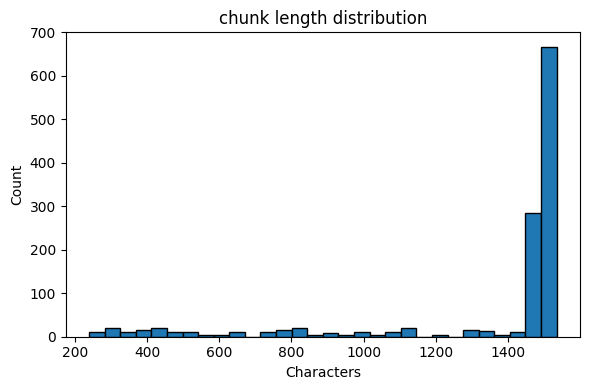

Count=1223, Min=239, Max=1535, Mean=1345.5, Median=1495.0


In [46]:
import matplotlib.pyplot as plt

lengths = df['chunk'].str.len()

plt.figure(figsize=(6,4))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title('chunk length distribution')
plt.xlabel('Characters')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Count={len(lengths)}, Min={lengths.min()}, Max={lengths.max()}, Mean={lengths.mean():.1f}, Median={lengths.median()}")


## 7) Split into train and evaluation datasets and save to CSV

This CSV can be loaded by your **RAG evaluation** notebook to compute **Recall@K, Precision@K, MAP, and MRR**.


In [47]:
# Split df into two equal parts, ensuring no duplicate chunk_ids in each
# First, get unique chunk_ids and shuffle them
unique_chunk_ids = df['chunk_id'].unique().tolist()
random.shuffle(unique_chunk_ids)

# Split chunk_ids into two equal parts
split_point = len(unique_chunk_ids) // 2
train_chunk_ids = unique_chunk_ids[:split_point]
valid_chunk_ids = unique_chunk_ids[split_point:]

# Create train and validation dataframes based on chunk_id splits
train_df = df[df['chunk_id'].isin(train_chunk_ids)].copy()
valid_df = df[df['chunk_id'].isin(valid_chunk_ids)].copy()

print(f"Train set: {len(train_df)} Q/A pairs from {len(train_chunk_ids)} unique chunks")
print(f"Valid set: {len(valid_df)} Q/A pairs from {len(valid_chunk_ids)} unique chunks")
print(f"Overlap check: {len(set(train_chunk_ids).intersection(set(valid_chunk_ids)))} chunks in both (should be 0)")

Train set: 607 Q/A pairs from 125 unique chunks
Valid set: 616 Q/A pairs from 126 unique chunks
Overlap check: 0 chunks in both (should be 0)


Overlap check: 0 chunks in both (should be 0)


In [48]:


train_df.to_csv(TRAIN_CSV, index=False)
print(f"Saved training dataset to: {TRAIN_CSV}")

valid_df.to_csv(VALID_CSV, index=False)
print(f"Saved evaluation dataset to: {VALID_CSV}")


Saved training dataset to: rag_train_dataset.csv
Saved evaluation dataset to: rag_eval_dataset.csv


In [38]:
!ls -la

total 2368
drwxr-xr-x.  4 kperkins411 kperkins411    4096 Nov 19 13:45 .
drwxr-xr-x. 16 kperkins411 kperkins411    4096 Nov 14 13:22 ..
drwxr-xr-x.  2 kperkins411 kperkins411      28 Nov 14 17:37 chroma
-rw-r--r--.  1 kperkins411 kperkins411  112025 Nov 19 14:04 Chroma_QA_Eval_Generator.ipynb
drwxr-xr-x.  2 kperkins411 kperkins411      46 Nov 14 17:44 __pycache__
-rw-r--r--.  1 kperkins411 kperkins411 1023893 Nov 19 14:04 rag_eval_dataset.csv
-rw-r--r--.  1 kperkins411 kperkins411   69772 Nov 19 13:45 rag_eval_per_query_metrics.csv
-rw-r--r--.  1 kperkins411 kperkins411   45875 Nov 19 13:45 RAG_Evaluate_with_rag_api.ipynb
-rw-r--r--.  1 kperkins411 kperkins411   22484 Nov 17 13:23 RAG_Metrics_Practice_Notebook.ipynb
-rw-r--r--.  1 kperkins411 kperkins411    7664 Nov 14 17:44 rag_pipeline_api.py
-rw-r--r--.  1 kperkins411 kperkins411   74900 Nov 14 17:19 RAG_Retriever_Eval_with_BM25.ipynb
-rw-r--r--.  1 kperkins411 kperkins411 1041530 Nov 19 14:04 rag_train_dataset.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



## 8) Tips & Next Steps

- **Quality control:** Spot‑check a few rows to ensure questions are **answerable from the chunk** and answers are **faithful**.  
- **Stronger models ⇒ better Q/A:** If using HF on CPU (e.g., `flan‑t5‑base`), consider upgrading to a stronger instruct model on GPU for higher‑quality questions.  
- **De‑duplication:** Remove near‑duplicate questions across chunks to reduce evaluation bias.  
- **Balance sampling:** You can stratify sampling by source/file/topic to ensure coverage.  
- **Costs:** OpenAI usage scales with tokens; keep chunks truncated and sample fraction small to control spend.
